# Predicting Habitable Exoplanets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('hwc.csv')

In [3]:
data.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [6]:
pd.options.display.max_rows = 200
data.dtypes

P_NAME                          object
P_DETECTION                     object
P_DISCOVERY_FACILITY            object
P_YEAR                           int64
P_UPDATE                        object
P_MASS                         float64
P_MASS_ERROR_MIN               float64
P_MASS_ERROR_MAX               float64
P_MASS_LIMIT                     int64
P_MASS_ORIGIN                   object
P_RADIUS                       float64
P_RADIUS_ERROR_MIN             float64
P_RADIUS_ERROR_MAX             float64
P_RADIUS_LIMIT                   int64
P_PERIOD                       float64
P_PERIOD_ERROR_MIN             float64
P_PERIOD_ERROR_MAX             float64
P_PERIOD_LIMIT                   int64
P_SEMI_MAJOR_AXIS              float64
P_SEMI_MAJOR_AXIS_ERROR_MIN    float64
P_SEMI_MAJOR_AXIS_ERROR_MAX    float64
P_SEMI_MAJOR_AXIS_LIMIT          int64
P_ECCENTRICITY                 float64
P_ECCENTRICITY_ERROR_MIN       float64
P_ECCENTRICITY_ERROR_MAX       float64
P_ECCENTRICITY_LIMIT     

### Sort columns from most null values - least null values

Column name  [null count, percent nulls]

In [8]:
nulls = {}

for column in data.columns: 
    if data[column].isna().sum() > 0:
        nulls[column] = [data[column].isna().sum(),((data[column].isna().sum())/5569)*100]
        
nulls = pd.Series(nulls)
nulls = nulls.sort_values(ascending=False)


In [5]:
nulls

S_NAME_HD                    [4603, 82.6539773747531]
S_NAME_HIP                  [4554, 81.77410666187825]
P_OMEGA_ERROR_MAX           [4063, 72.95744298796912]
P_OMEGA_ERROR_MIN           [4063, 72.95744298796912]
P_ECCENTRICITY_ERROR_MIN    [3976, 71.39522355898725]
                                      ...            
P_DISTANCE                   [4, 0.07182618064284432]
P_PERIASTRON                 [4, 0.07182618064284432]
S_TIDAL_LOCK                 [4, 0.07182618064284432]
P_APASTRON                   [4, 0.07182618064284432]
S_MASS                       [4, 0.07182618064284432]
Length: 85, dtype: object

### Delete columns with null values > 40%

In [4]:
data.drop(columns=["S_NAME_HD","S_NAME_HIP","P_OMEGA_ERROR_MAX","P_OMEGA_ERROR_MIN","P_ECCENTRICITY_ERROR_MIN","P_ECCENTRICITY_ERROR_MAX","P_OMEGA",
                   "P_INCLINATION_ERROR_MAX","P_INCLINATION_ERROR_MIN","S_TYPE","P_TEMP_SURF","P_MASS_ERROR_MIN","P_MASS_ERROR_MAX","P_SEMI_MAJOR_AXIS_ERROR_MAX",
                   "P_SEMI_MAJOR_AXIS_ERROR_MIN","S_LOG_LUM_ERROR_MIN","S_LOG_LUM_ERROR_MAX"], inplace=True)

In [4]:
data['P_TYPE'].dtypes

dtype('O')

In [9]:
nulls.count()

68

### Among the remaining columns with null values, find those with type = str

In [10]:
objects = []
for column in data.columns:
    if data[column].isna().sum() > 0 and data[column].dtype == 'O':
        objects.append(column)

objects

['P_TYPE', 'S_TYPE_TEMP', 'P_TYPE_TEMP']

### Mode imputation

In [5]:
data['P_TYPE_TEMP'] = data['P_TYPE_TEMP'].fillna(data['P_TYPE_TEMP'].mode()[0])
data['S_TYPE_TEMP'] = data['S_TYPE_TEMP'].fillna(data['S_TYPE_TEMP'].mode()[0])
data['P_TYPE'] = data['P_TYPE'].fillna(data['P_TYPE'].mode()[0])

In [6]:
objects = []
for column in data.columns:
    if data[column].isna().sum() > 0 and data[column].dtype == 'O':
        objects.append(column)

objects

[]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Columns: 101 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(67), int64(18), object(16)
memory usage: 4.3+ MB


### Find all columns with type = str

In [7]:
copydata = data.copy()

In [9]:
objs = copydata.select_dtypes(include='O')
list(objs)

['P_NAME',
 'P_DETECTION',
 'P_DISCOVERY_FACILITY',
 'P_UPDATE',
 'P_MASS_ORIGIN',
 'S_NAME',
 'S_RA_STR',
 'S_DEC_STR',
 'P_TYPE',
 'S_TYPE_TEMP',
 'S_RA_TXT',
 'S_DEC_TXT',
 'P_TYPE_TEMP',
 'S_CONSTELLATION',
 'S_CONSTELLATION_ABR',
 'S_CONSTELLATION_ENG']

### Encode all columns with type = str using LabelEncoder

In [10]:
from sklearn.preprocessing import LabelEncoder 
  
collist = list(objs)

for col in collist:
    encoder = LabelEncoder() 
    copydata[col] = encoder.fit_transform(copydata[col])


In [8]:
strings = copydata.select_dtypes(include='O')
list(strings)

[]

### Drop all error columns because they are outside the scope of this project

In [11]:
for col in copydata.columns:
    if "ERROR" in col: 
        copydata.drop(columns=col, inplace=True)

In [19]:
bools = list(copydata.select_dtypes(include='bool'))
bools

[]

In [20]:
corr_matrix = copydata.corr().abs()
s = corr_matrix.unstack()
so = s.sort_values(ascending=False)
count=0
for value in so: 
    if value == 1:
        count+=1

count

89

In [21]:
sos = so[89:]
count=0
for value in sos: 
    if value >= .95:
        count+=1
count

pd.options.display.max_rows = 300
sos[:49]

P_TEMP_EQUIL_MAX   P_TEMP_SURF_MAX      1.000000
P_TEMP_SURF_MAX    P_TEMP_EQUIL_MAX     1.000000
P_TEMP_SURF_MIN    P_TEMP_EQUIL_MIN     1.000000
P_TEMP_EQUIL_MIN   P_TEMP_SURF_MIN      1.000000
S_HZ_OPT_MAX       S_HZ_CON1_MAX        1.000000
                   S_HZ_CON_MAX         1.000000
S_HZ_CON_MAX       S_HZ_OPT_MAX         1.000000
S_HZ_CON1_MAX      S_HZ_OPT_MAX         1.000000
S_HZ_OPT_MAX       S_HZ_CON0_MAX        1.000000
S_HZ_CON0_MAX      S_HZ_OPT_MAX         1.000000
S_HZ_OPT_MIN       S_HZ_CON_MIN         1.000000
S_HZ_CON_MIN       S_HZ_OPT_MIN         1.000000
S_HZ_CON1_MIN      S_HZ_CON_MIN         1.000000
S_HZ_CON_MIN       S_HZ_CON1_MIN        1.000000
S_HZ_CON1_MIN      S_HZ_OPT_MIN         1.000000
S_HZ_OPT_MIN       S_HZ_CON1_MIN        1.000000
S_HZ_CON1_MIN      S_HZ_CON0_MIN        0.999999
S_HZ_CON0_MIN      S_HZ_CON1_MIN        0.999999
S_HZ_CON_MIN       S_HZ_CON0_MIN        0.999999
S_HZ_CON0_MIN      S_HZ_CON_MIN         0.999999
S_HZ_OPT_MIN       S

In [22]:
hab_corr = corr_matrix.loc[["P_HABITABLE"]].transpose()
hab_corr.sort_values(by="P_HABITABLE", ascending=False)


,P_HABITABLE
P_HABITABLE,1.000000
P_HABZONE_OPT,0.479930
P_ESI,0.387213
P_TYPE_TEMP,0.326450
P_HABZONE_CON,0.317465
S_LOG_LUM,0.206002
S_TYPE_TEMP,0.150383
S_AGE_LIMIT,0.130480
S_LOG_G_LIMIT,0.130480
S_TIDAL_LOCK,0.128172


### Consider these columns to have multicolinarity 

Similar to margin of error (often min = max which is redundant)

P_TEMP_SURF_MAX
PTEMPSURFMIN
PTEMPEQUILMIN
PTEMPEQUILMAX

PDISTANCE = PHILLSPHERE = PAPASTRON = PPERIASTRON = PERIOD

DISTANCE = PERIOD = SEMIMAJORAXIS

HILLSPHERE = SEMIMAJORAXIS

HILLSPHERE = PERIOD

CONSTELLATION = CONS_ABR

### DROP REDUNDANT COLUMNS 

KEEP DISTANCE
DROP SEMIMAJORAXIS, PERIOD, PERIASTRON, ASTRON, HILL SPHERE

KEEP TEMP EQUIL
DROP TEMPSURF, SURF MIN, SURF MAX, EQUIL MIN, EQUIL MAX

KEEP SNOWLINE 
DROP HZ OP HZ CON MIN AND MAX 

DROP CONSTELLATION ABR

In [12]:
copydata.drop(columns=["S_HZ_CON0_MIN", "P_SEMI_MAJOR_AXIS", "P_DISTANCE_EFF", "P_PERIASTRON","P_APASTRON", "S_CONSTELLATION_ABR","S_HZ_CON0_MAX", 
                       "S_HZ_CON1_MAX", "S_HZ_CON0_MAX", "S_HZ_CON_MAX", "S_HZ_OPT_MAX", "S_NAME", "P_HILL_SPHERE","P_TEMP_EQUIL_MAX", "P_TEMP_SURF_MAX","P_TEMP_SURF_MIN", 
                       "P_TEMP_EQUIL_MIN"], inplace=True)

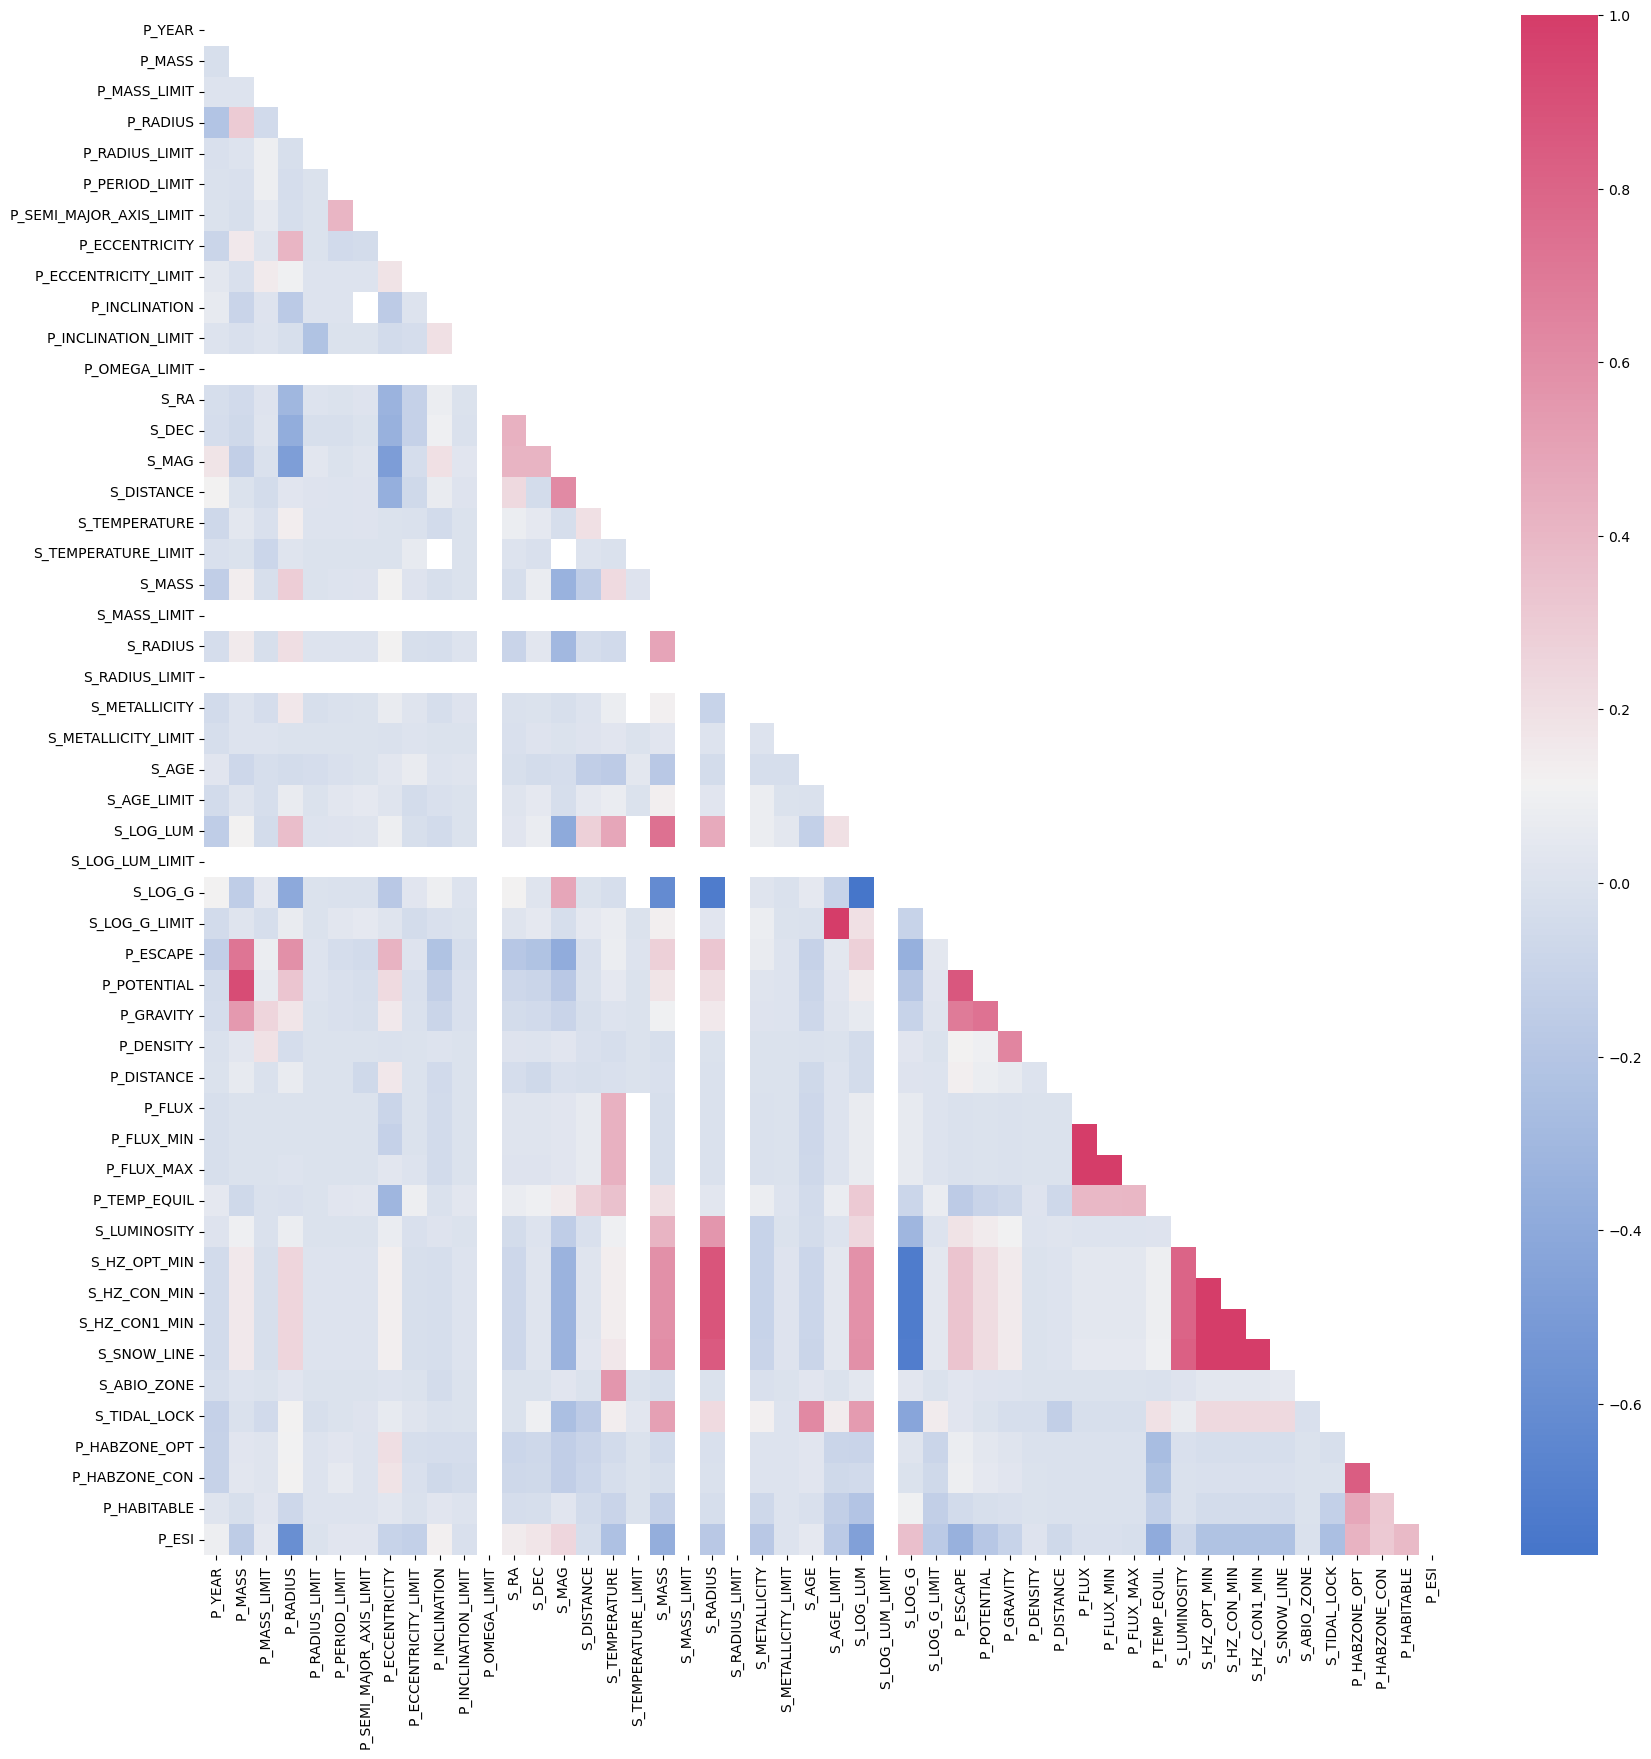

In [17]:
corr_matrix = copydata.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype = np.bool_))
cmap = sns.diverging_palette(255, 0, as_cmap = True)

plt.figure(figsize=(20,20))
sns.heatmap(data=corr_matrix, mask=mask, cmap=cmap)
plt.show()

### Remove all columns with "LIMIT" because this is outside the scope of the project 

In [13]:
for col in copydata.columns:
    if "LIMIT" in col: 
        copydata.drop(columns=col, inplace=True)

In [25]:
copydata.shape

(5569, 50)

In [ ]:
'P_PERIOD', 'P_FLUX', 'P_TEMP_EQUIL','P_TYPE', 'P_HABZONE_OPT','P_RADIUS_EST', 'P_MASS_EST', 'S_TYPE_TEMP']

'P_HABZONE_OPT', 'P_ESI', 'P_TYPE_TEMP','S_LOG_LUM', 'S_TIDAL_LOCK', 'P_TEMP_EQUIL', 'P_TYPE'

In [26]:
corr_matrix = copydata.corr().abs()
hab_corr = corr_matrix.loc[["P_HABITABLE"]].transpose()
hab_corr.sort_values(by="P_HABITABLE", ascending=False)

,P_HABITABLE
P_HABITABLE,1.000000
P_HABZONE_OPT,0.479930
P_ESI,0.387213
P_TYPE_TEMP,0.326450
P_HABZONE_CON,0.317465
S_LOG_LUM,0.206002
S_TYPE_TEMP,0.150383
S_TIDAL_LOCK,0.128172
P_TEMP_EQUIL,0.124525
S_MASS,0.121056


In [14]:
copydata.drop(columns=["S_HZ_OPT_MIN","S_HZ_CON_MIN", "S_HZ_CON1_MIN", "P_FLUX_MIN"], inplace=True)

### MICE imputation of remaining null values

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(copydata)
newdata = pd.DataFrame(imputed, columns=copydata.columns)

In [29]:
newdata.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_ECCENTRICITY,P_INCLINATION,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ENG
0,4852.0,4.0,43.0,2020.0,144.0,250.00,1.0,13.90,0.076464,-13023.184196,...,2.009683,1.019592e+35,0.214133,0.0,0.0,1.0,0.0,0.038072,72.0,63.0
1,3536.0,9.0,27.0,2013.0,92.0,16.60,1.0,2.90,0.000000,86.920000,...,2.437046,2.097783e+00,0.316980,0.0,0.0,1.0,0.0,0.272032,30.0,75.0
2,4492.0,9.0,27.0,2016.0,109.0,5.10,0.0,2.11,0.000000,89.820000,...,2.827247,1.756317e+00,0.459559,0.0,0.0,1.0,0.0,0.254763,51.0,49.0
3,1579.0,9.0,21.0,2018.0,125.0,12.20,0.0,3.52,0.076442,117.630067,...,1.476943,5.683741e-01,0.443760,0.0,0.0,1.0,0.0,0.193906,65.0,26.0
4,4004.0,9.0,27.0,2016.0,109.0,4.94,0.0,2.07,0.000000,87.750000,...,1.759397,7.685024e-01,0.386150,0.0,0.0,1.0,0.0,0.276721,51.0,49.0


In [14]:
newdata.isna().sum()

P_NAME                  0
P_DETECTION             0
P_DISCOVERY_FACILITY    0
P_YEAR                  0
P_UPDATE                0
P_MASS                  0
P_MASS_ORIGIN           0
P_RADIUS                0
P_ECCENTRICITY          0
P_INCLINATION           0
S_RA                    0
S_DEC                   0
S_RA_STR                0
S_DEC_STR               0
S_MAG                   0
S_DISTANCE              0
S_TEMPERATURE           0
S_MASS                  0
S_RADIUS                0
S_METALLICITY           0
S_AGE                   0
S_LOG_LUM               0
S_LOG_G                 0
P_ESCAPE                0
P_POTENTIAL             0
P_GRAVITY               0
P_DENSITY               0
P_DISTANCE              0
P_FLUX                  0
P_FLUX_MAX              0
P_TEMP_EQUIL            0
P_TYPE                  0
S_TYPE_TEMP             0
S_RA_TXT                0
S_DEC_TXT               0
S_LUMINOSITY            0
S_SNOW_LINE             0
S_ABIO_ZONE             0
S_TIDAL_LOCK

# EDA

In [50]:
newdata.describe()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_ECCENTRICITY,P_INCLINATION,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ENG
count,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5.569000e+03,...,5569.000000,5.569000e+03,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000,5569.000000
mean,2784.000000,8.513198,31.715748,2016.147603,161.078470,440.753376,0.790986,5.716841,0.076464,-1.302318e+04,...,2.009683,1.019592e+35,0.425936,0.047226,0.033579,0.983480,0.019573,0.038072,41.934997,53.783085
std,1607.776156,1.256969,13.157199,4.505797,72.509448,2369.161502,1.044855,5.337006,0.139893,6.659612e+05,...,81.098653,5.167176e+36,0.076978,0.212140,0.180158,0.332744,0.183196,11.101765,20.664615,24.618796
min,0.000000,0.000000,0.000000,1992.000000,0.000000,0.020000,0.000000,0.310000,0.000000,-3.514499e+07,...,-4261.987580,4.356319e-05,0.029269,0.000000,0.000000,0.000000,0.000000,-585.582379,0.000000,0.000000
25%,1392.000000,9.000000,27.000000,2014.000000,109.000000,4.040000,0.000000,1.780000,0.000000,8.720000e+01,...,1.647646,5.014684e-01,0.391783,0.000000,0.000000,1.000000,0.000000,0.157835,30.000000,36.000000
50%,2784.000000,9.000000,27.000000,2016.000000,125.000000,8.750000,0.000000,2.780000,0.000000,8.917000e+01,...,2.411925,1.446409e+00,0.443760,0.000000,0.000000,1.000000,0.000000,0.263108,35.000000,57.000000
75%,4176.000000,9.000000,36.000000,2020.000000,225.000000,165.260000,1.000000,11.893000,0.076464,8.998000e+01,...,3.813851,2.829876e+00,0.470443,0.000000,0.000000,1.000000,0.000000,0.299466,51.000000,75.000000
max,5568.000000,10.000000,69.000000,2023.000000,292.000000,89700.000000,3.000000,77.342000,0.950000,1.760920e+02,...,214.468620,2.726899e+38,1.003328,1.000000,1.000000,2.000000,2.000000,0.950573,87.000000,87.000000


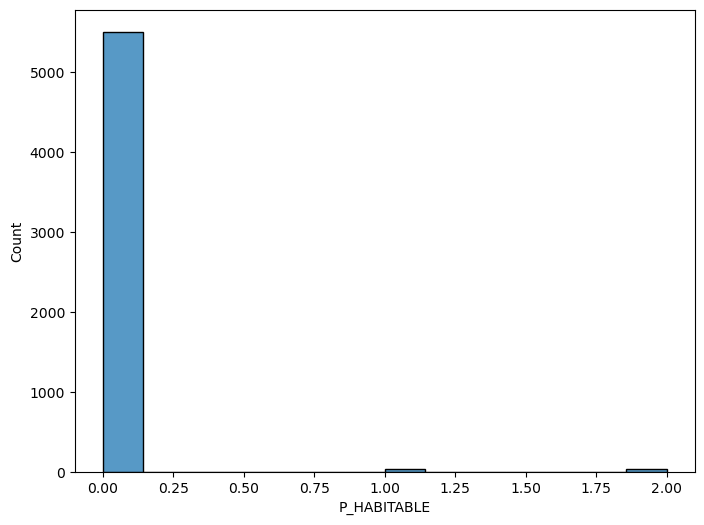

In [33]:
# histograms 

plt.figure(figsize=(8,6))
sns.histplot(data=newdata, x=newdata["P_HABITABLE"])
plt.show()

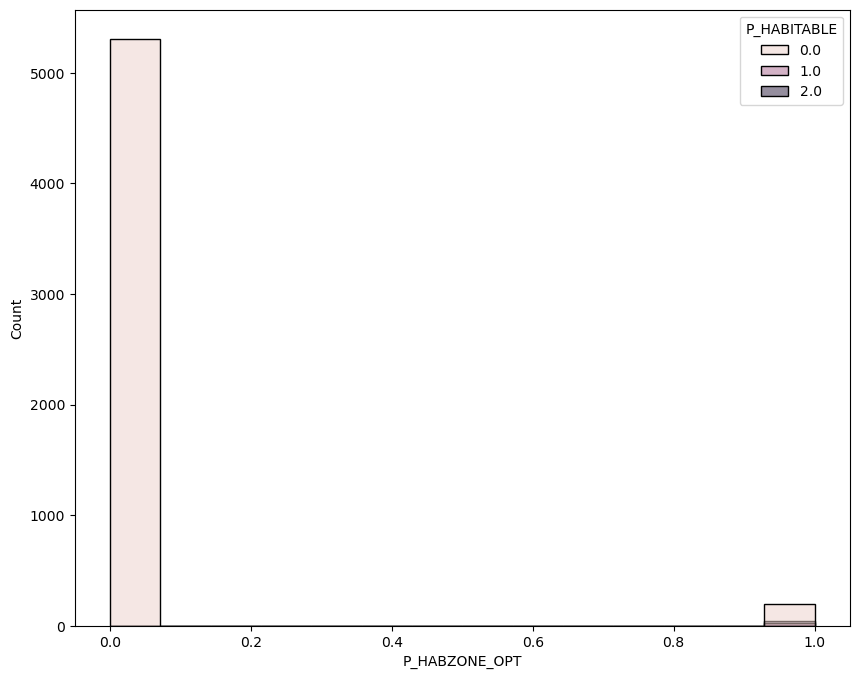

In [36]:
# scatterplots

plt.figure(figsize=(10,8))
sns.histplot(data=newdata, x='P_HABZONE_OPT', hue='P_HABITABLE')
plt.show()

### Unbalanced Values

In [69]:
values = pd.DataFrame(newdata['P_HABITABLE'].value_counts())
values['percentage'] = (values['P_HABITABLE']/ 5569)*100
values

,P_HABITABLE,percentage
0.0,5500,98.760998
2.0,40,0.718262
1.0,29,0.520740


### Data is highly unbalanced, to fix this we either need to DOWNSAMPLE or UPSAMPLE or UPWEIGHTfrom imblearn.combine import SMOTEENN

In [41]:
conda install -c conda-forge imbalanced-learn


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\eleanor\anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       h56e8100_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    imbalanced-learn-0.12.0    |     pyhd8ed1ab_0         155 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         464 KB

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2023.12.12~ --> conda-forge::ca-certificates-2024.2.2-h56e8100_0 
  imbalanced-learn   pkgs/main/win-64::imbalanced-learn-0.~ --> conda-forge/noarch::imbalanced-learn-0.12.0-pyhd8ed1ab_0 

The followi



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [17]:
from imblearn.combine import SMOTEENN

In [70]:
#feature_vars = ['P_HABZONE_OPT', 'P_ESI','S_LOG_LUM', 'S_TIDAL_LOCK', 'P_TEMP_EQUIL', 'P_TYPE']
#feature_vars = ['P_HABZONE_OPT', 'P_ESI', 'P_TYPE']
feature_vars = ['P_FLUX', 'P_PERIOD', 'P_RADIUS', 'P_TEMP_EQUIL', 'S_RADIUS','S_TEMPERATURE', 'S_DISTANCE']


X,y = newdata[feature_vars], newdata['P_HABITABLE']

#resample = SMOTEENN()
#Xnew, ynew = resample.fit_resample(X, y)

In [19]:
values = pd.DataFrame(ynew.value_counts())
values['percentage'] = (values['P_HABITABLE']/ len(ynew))*100
values

,P_HABITABLE,percentage
1.0,5420,33.491936
2.0,5407,33.411605
0.0,5356,33.096459


In [30]:
Xnew.shape

(16107, 45)

In [73]:
newdata['P_HABITABLE'].value_counts()

0.0    5500
2.0      40
1.0      29
Name: P_HABITABLE, dtype: int64

## Split Data

In [71]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, stratify=ynew, train_size=0.8, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)

## Run Model 

In [72]:
dec_tree=DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

print('Train score: '+str(dec_tree.score(X_train,y_train)))
print('Test score: '+str(dec_tree.score(X_test,y_test)))

Train score: 1.0
Test score: 0.9982046678635548


Train score: 1.0
Test score: 0.9996962332928311


In [74]:
feature_importances=pd.DataFrame({'Feature':X.columns,'Feature Importance':dec_tree.feature_importances_})
display(feature_importances)

,Feature,Feature Importance
0,P_FLUX,0.270667
1,P_PERIOD,0.015731
2,P_RADIUS,0.470203
3,P_TEMP_EQUIL,0.145577
4,S_RADIUS,0.080059
5,S_TEMPERATURE,0.000000
6,S_DISTANCE,0.017761


In [75]:
predictions = dec_tree.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1100
         1.0       1.00      1.00      1.00         6
         2.0       0.88      0.88      0.88         8

    accuracy                           1.00      1114
   macro avg       0.96      0.96      0.96      1114
weighted avg       1.00      1.00      1.00      1114



In [86]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=500) #1000 decision makers is often a good number to go for
rf.fit(X_train, y_train)

print('Train score: '+str(rf.score(X_train,y_train)))
print('Test score: '+str(rf.score(X_test,y_test)))

Train score: 1.0
Test score: 0.9973070017953322


In [24]:
proposed = pd.read_csv('proposed1.csv')

In [48]:
proposed.columns.to_list()

['toi',
 'tid',
 'tfopwg_disp',
 'rastr',
 'ra',
 'decstr',
 'dec',
 'st_pmra',
 'st_pmdec',
 'pl_tranmid',
 'pl_orbper',
 'pl_trandurh',
 'pl_trandep',
 'pl_rade',
 'pl_insol',
 'pl_eqt',
 'st_tmag',
 'st_dist',
 'st_teff',
 'st_logg',
 'st_rad',
 'toi_created',
 'rowupdate']

## Same columns: 

P_FLUX > pl_insol

P_PERIOD > pl_orbper

P_RADIUS > pl_rade

P_TEMP_EQUIL > pl_eqt

S_RADIUS > st_rad

S_TEMPERATURE > st_teff

S_DISTANCE > st_dist


In [68]:
proposed.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmdec,pl_tranmid,...,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad,toi_created,rowupdate
0,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,-15.555,2459987.949,...,11.21540,44464.500000,4045.000000,9.42344,295.862,7070.0,4.03,2.01,7/24/2019 15:58,4/3/2023 14:31
1,1007.01,65212867,PC,07h31m00.57s,112.752393,-04d27m48.09s,-4.463359,0.357,3.399,2459247.931,...,14.77520,448.744000,1282.000000,8.87759,283.291,6596.0,3.71,2.70,7/24/2019 15:58,10/29/2021 12:59
2,1009.01,107782586,PC,07h26m40.28s,111.667845,-24d27m43.6s,-24.462111,-3.297,4.849,2459229.231,...,NaN,1063.342296,1456.424653,8.43310,866.147,8868.7,NaN,NaN,7/24/2019 15:58,1/17/2024 10:08
3,1011.01,114018671,PC,07h35m56.34s,113.984761,-32d50m31.2s,-32.841999,145.102,-134.901,2459984.628,...,1.44656,575.597000,1364.000000,8.23880,52.620,5413.7,4.46,0.94,7/24/2019 15:58,3/22/2023 16:02
4,1012.01,427508467,APC,07h48m22.87s,117.095285,+06d47m06.23s,6.785064,-2.990,-0.029,2459252.510,...,24.81320,112144.000000,5098.000000,8.12718,295.959,8928.0,3.92,2.72,7/24/2019 15:58,3/10/2023 12:02


In [69]:
proposed.isna().sum()

toi              0
tid              0
tfopwg_disp      0
rastr            0
ra               0
decstr           0
dec              0
st_pmra         92
st_pmdec        92
pl_tranmid       0
pl_orbper       78
pl_trandurh      0
pl_trandep       0
pl_rade        349
pl_insol        90
pl_eqt         185
st_tmag          0
st_dist        158
st_teff         92
st_logg        584
st_rad         349
toi_created      0
rowupdate        0
dtype: int64

In [77]:
proposedcopy = proposed.copy()

objs = proposedcopy.select_dtypes(include='O')

collist = list(objs)

for col in collist:
    encoder = LabelEncoder() 
    proposedcopy[col] = encoder.fit_transform(proposedcopy[col])

In [78]:
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(proposedcopy)
newproposed = pd.DataFrame(imputed, columns=proposedcopy.columns)

In [79]:
newproposed.isna().sum()

toi            0
tid            0
tfopwg_disp    0
rastr          0
ra             0
decstr         0
dec            0
st_pmra        0
st_pmdec       0
pl_tranmid     0
pl_orbper      0
pl_trandurh    0
pl_trandep     0
pl_rade        0
pl_insol       0
pl_eqt         0
st_tmag        0
st_dist        0
st_teff        0
st_logg        0
st_rad         0
toi_created    0
rowupdate      0
dtype: int64

In [79]:
predictX = ['pl_insol', 'pl_orbper', 'pl_rade', 'pl_eqt', 'st_rad', 'st_teff', 'st_dist']

predict = newproposed[predictX]

predict.rename(columns={'pl_insol': 'P_FLUX', 'pl_orbper': 'P_PERIOD', 'pl_rade': 'P_RADIUS', 'pl_eqt': 'P_TEMP_EQUIL', 'st_rad': 'S_RADIUS', 
               'st_teff': 'S_TEMPERATURE', 'st_dist': 'S_DISTANCE'}, inplace=True)

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_19920\275294265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict.rename(columns={'pl_insol': 'P_FLUX', 'pl_orbper': 'P_PERIOD', 'pl_rade': 'P_RADIUS', 'pl_eqt': 'P_TEMP_EQUIL', 'st_rad': 'S_RADIUS',


In [80]:
results = dec_tree.predict(predict)

In [81]:
results = pd.Series(results)
results.value_counts()

0.0    4998
2.0      19
1.0       3
dtype: int64

In [82]:
predict['result'] = results

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_19920\2859636108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['result'] = results


In [42]:
predict.head()

,P_FLUX,P_PERIOD,P_RADIUS,P_TEMP_EQUIL,S_RADIUS,S_TEMPERATURE,S_DISTANCE,result
0,44464.500000,1.931646,11.215400,4045.000000,2.010000,7070.0,295.862,0.0
1,448.744000,6.998921,14.775200,1282.000000,2.700000,6596.0,283.291,0.0
2,1063.342296,1.960028,7.118335,1456.424653,2.112755,8868.7,866.147,0.0
3,575.597000,2.470498,1.446560,1364.000000,0.940000,5413.7,52.620,0.0
4,112144.000000,0.884182,24.813200,5098.000000,2.720000,8928.0,295.959,0.0


In [58]:
type(predict['result'][0])

numpy.float64

In [83]:
hab = {}

for i, element in enumerate(predict["result"]):
    if element == 1 or element == 2:
        row = predict.iloc[i]
        hab[i] = row


In [84]:
hab = pd.DataFrame(hab).transpose()

In [85]:
hab

,P_FLUX,P_PERIOD,P_RADIUS,P_TEMP_EQUIL,S_RADIUS,S_TEMPERATURE,S_DISTANCE,result
463,1.388026,1071.089845,2.240778,276.833818,0.701499,4755.33,20.5272,2.0
633,0.857412,243.938548,1.633089,245.424045,0.852643,5599.00,99.9023,2.0
643,0.290998,31.156121,2.432614,187.323524,0.128000,2808.00,52.3436,1.0
786,0.381980,77.253253,1.810310,200.507208,0.308919,3323.00,32.6094,2.0
2346,0.467105,742.856116,2.275614,210.849927,1.101940,5816.00,83.9132,2.0
2439,0.677144,722.261976,2.720708,231.360916,1.220590,5857.00,125.0770,2.0
2464,0.306659,703.793670,1.860295,189.794513,0.739835,4709.00,25.0039,2.0
2484,0.431256,718.180932,1.365309,206.682479,0.425623,3614.00,25.1426,1.0
2490,0.611236,741.425590,2.768348,225.513196,1.220390,5944.00,98.2063,2.0
2595,0.836482,710.698202,2.092840,243.912386,0.796254,5334.00,62.5050,2.0
